In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import os
from torchvision import datasets, transforms, models
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
#         print(images.shape)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std

In [3]:
def train_transform(dataset):
    train_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
    train_dataset=torchvision.datasets.ImageFolder(root=dataset,transform=train_transforms)
    train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=32,shuffle=True)
    mean,std=get_mean_std(train_loader)
    train_transforms = transforms.Compose([
        transforms.Resize((255,255)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    train_dataset=torchvision.datasets.ImageFolder(root=dataset,transform=train_transforms)
    train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=64,shuffle=True,drop_last=False,num_workers=0)
    return train_loader,train_dataset

In [4]:
train_dataset='../Datasets/dataset_2_classes/train/'
train_loader,training_dataset=train_transform(train_dataset)

In [5]:
resnet18_Model = models.resnet18(pretrained=False,num_classes=2)

/Users/bhanuprakash/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bhanuprakash/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
feature_extractor = torch.nn.Sequential(*list(resnet18_Model.children())[:-1])
features = []
labels = []
with torch.no_grad():
    for images, batch_labels in train_loader:
        batch_features = feature_extractor(images)
        batch_features = torch.flatten(batch_features, start_dim=1)
        features.append(batch_features)
        labels.append(batch_labels)
features = torch.cat(features, dim=0)
labels = torch.cat(labels, dim=0)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1024 samples in 0.001s...
[t-SNE] Computed neighbors for 1024 samples in 0.043s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1024
[t-SNE] Computed conditional probabilities for sample 1024 / 1024
[t-SNE] Mean sigma: 0.507614
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.272308
[t-SNE] KL divergence after 1000 iterations: 0.304020


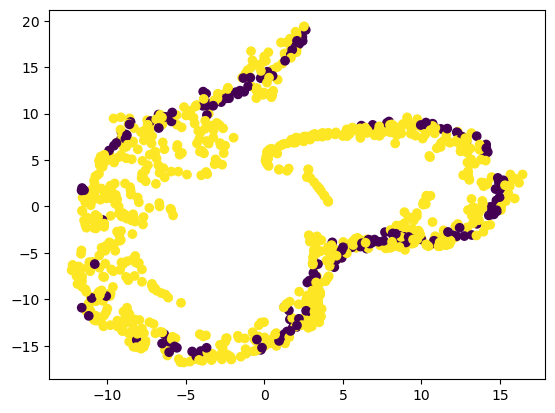

In [11]:
distances = pairwise_distances(features.numpy())
sigma = torch.median(torch.tensor(distances)).item()
similarities = torch.exp(-torch.tensor(distances)**2 / (2 * sigma**2))

# Compute t-SNE embeddings
tsne = TSNE(n_components=3, perplexity=30, verbose=1)
embeddings = tsne.fit_transform(similarities.numpy())

# Plot the embeddings
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels.numpy())
plt.show()